# 🧠🔎 TIF Document Pipeline: OCR Page Detection, Photo Extraction, and Similarity Search

This client-ready notebook demonstrates an end-to-end workflow for:
- Detecting relevant pages in multi-page TIFs using OCR
- Extracting photos from pages (YOLO or BBox)
- Building an index and running document/image similarity searches

It is organized into clear sections with robust logging and configuration to enable reproducible, professional runs.

## 0) 📋 Environment & Logging Setup

In [1]:
# -------------------------------------------------------------------------------------------------
# Robust logging for Jupyter (console + optional file)
# -------------------------------------------------------------------------------------------------
import logging
import sys
from pathlib import Path

# --- Configuration ---
LOG_TO_FILE = True  # Set to False to log only to the console
LOG_LEVEL = logging.INFO
LOG_FORMAT = "%(asctime)s - [%(levelname)s] - %(name)s - %(message)s"
LOG_DIR = Path('./notebook_logs')
LOG_FILE = LOG_DIR / 'pipeline_run.log'

# --- Setup ---
handlers = [logging.StreamHandler(sys.stdout)]
if LOG_TO_FILE:
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    file_handler = logging.FileHandler(LOG_FILE, mode='w', encoding='utf-8')
    file_handler.setFormatter(logging.Formatter(LOG_FORMAT))
    handlers.append(file_handler)

# Configure root logger
logging.basicConfig(level=LOG_LEVEL, format=LOG_FORMAT, handlers=handlers, force=True)

# --- Set Log Levels for Specific Libraries ---
logging.getLogger('external.photo_extractor').setLevel(LOG_LEVEL)
logging.getLogger('PIL.PngImagePlugin').setLevel(logging.WARNING)
logging.getLogger('ultralytics').setLevel(logging.WARNING)

logger = logging.getLogger(__name__)
if LOG_TO_FILE:
    logger.info('Logging configured: console + file at %s', str(LOG_FILE.resolve()))
else:
    logger.info('Logging configured: console only')

2025-09-02 15:14:13,169 - [INFO] - __main__ - Logging configured: console + file at D:\frm_git\tif_doc_nd_image_similarity_search\TifDoc_nd_image_similarity_search\notebook_logs\pipeline_run.log


## 1) ⚙️ Configuration and Initialization

In [2]:
# -------------------------------------------------------------------------------------------------
# Paths, sys.path, imports, and configuration loading
# -------------------------------------------------------------------------------------------------
import sys, copy
from pathlib import Path
from typing import List, Dict, Any

PROJECT_ROOT = Path.cwd()
MAIN_OUTPUT_DIRECTORY = PROJECT_ROOT / 'pipeline_outputs'
INPUT_DATA_DIRECTORY = PROJECT_ROOT / 'data_real'  # Folder with .tif/.tiff files (recursively scanned)
SIMILARITY_CONFIG_PATH = PROJECT_ROOT / 'configs' / 'image_similarity_config.yaml'
TOP_DOCUMENTS_TO_RETURN = 5

# Ensure output directories exist
(MAIN_OUTPUT_DIRECTORY / 'extracted_crops').mkdir(parents=True, exist_ok=True)

# sys.path for vendored libraries and project
if str(PROJECT_ROOT) not in sys.path: sys.path.insert(0, str(PROJECT_ROOT))
EXT_DIR = PROJECT_ROOT / 'external'
if EXT_DIR.is_dir() and str(EXT_DIR) not in sys.path: sys.path.insert(0, str(EXT_DIR))

# Core engine imports
from core_engine.image_similarity_system.workflow import (
    execute_tif_batch_search_workflow,
    build_index_from_tif_folder_workflow,
    execute_image_similarity_workflow,
)
from core_engine.image_similarity_system.config_loader import load_config

# Vendored libs for optional OCR pre-pass and photo extraction config interface
from external.tif_searcher import TifTextSearcher
from external.photo_extractor import PhotoExtractor

logging.info('Project root: %s', PROJECT_ROOT)

# --- Load Similarity Config ---
similarity_config = None
try:
    similarity_config = load_config(primary_config_path=str(SIMILARITY_CONFIG_PATH))
    logging.info('Similarity config loaded successfully from %s', SIMILARITY_CONFIG_PATH)
except Exception as e:
    logging.error('Failed to load similarity config: %s', e, exc_info=True)
    # In a notebook, we raise to stop execution if the core config is missing
    raise

# --- YOLO configuration, photo_extractor_config (pec) for PhotoExtractor (used inside workflows) ---
# gpu_inference: 'true' (GPU-only), 'false' (CPU-only), 'auto' (GPU with CPU fallback)
photo_extractor_config: Dict[str, Any] = {
    'yolo_object_detection': {
        'model_path': str(PROJECT_ROOT / 'trained_model' / 'weights' / 'best.pt'),
        'inference': {
            'target_object_names': ['photo'],
            'confidence_threshold': 0.25,
            'iou_threshold': 0.45,
            'imgsz': 640,
            'gpu_inference': 'auto',
        }
    }
}

# --- Bounding Box extraction configuration (used in BBox mode sections) ---
BBOX_LIST: List[List[int]] = [[50, 60, 300, 260]]
BBOX_FORMAT = 'xyxy'
BBOX_NORMALIZED = False

# --- TifTextSearcher overrides for OCR page detection (mirror vendored defaults) ---
searcher_overrides: Dict[str, Any] = {
    'search_text': '가맹점 실사 사진',
    'language': 'ko',
    'ocr_backend': 'paddleocr',
    'search_mode': 'exact_phrase',
    'allow_normalization': True,
    'remove_spaces_in_normalization': True,
    'recognized_text_debug': True,
    'search_location': {'top': 0.05},
    'use_offline_models': False,
    'use_angle_cls': True,
    'use_gpu_for_paddle': True,
    'paddle_batch_size': 6,
    'download_path_det_model': '',
    'download_path_rec_model': '',
    'download_path_cls_model': '',
    'offline_paddle_det_model_dir': r'C:\\Users\\jeeb\\.paddlex\\official_models\\PP-OCRv3_det',
    'offline_paddle_rec_model_dir': r'C:\\Users\\jeeb\\.paddlex\\official_models\\korean_PP-OCRv3_rec',
    'offline_paddle_cls_model_dir': r'C:\\Users\\jeeb\\.paddlex\\official_models\\ch_ppocr_mobile_v2.0_cls_infer',
    'offline_easyocr_model_dir': r'C:\\ocr_models\\.EasyOCR',
    'tesseract_cmd_path': 'tesseract',
}

2025-09-02 15:14:16,146 - [INFO] - faiss.loader - Loading faiss with AVX2 support.
2025-09-02 15:14:16,218 - [INFO] - faiss.loader - Successfully loaded faiss with AVX2 support.


In [3]:
# 1B) Input mode selection for TIF workflows: 'tif' (folder) or 'key' (helper module)
INPUT_MODE = 'tif'  # options: 'tif' | 'key'
KEY_INPUT_CONFIG_PATH = PROJECT_ROOT / 'external' / 'key_input' / 'key_input_config.yaml'
if INPUT_MODE.lower() == 'key':
    try:
        from external.key_input.key_input_orchestrator import run_key_input_pipeline
    except Exception as e:
        raise RuntimeError(f"Key-driven helper is unavailable: {e}")
    # Ensure the main config reflects the mode, then delegate to helper
    import yaml
    with open(SIMILARITY_CONFIG_PATH, 'r', encoding='utf-8') as f:
        _cfg = yaml.safe_load(f) or {}
    _cfg.setdefault('input_mode', {})['doc_input_start'] = 'key'
    _cfg['input_mode']['key_input_config_path'] = str(KEY_INPUT_CONFIG_PATH)
    with open(SIMILARITY_CONFIG_PATH, 'w', encoding='utf-8') as f:
        yaml.safe_dump(_cfg, f, allow_unicode=True, sort_keys=False)
    print('[Notebook] Running key-driven TIF pipeline using', KEY_INPUT_CONFIG_PATH)
    result = run_key_input_pipeline(SIMILARITY_CONFIG_PATH)
    from pprint import pprint
    pprint(result)
    KEY_PIPELINE_COMPLETED = True
else:
    # Ensure config is set to default 'tif' mode for consistency
    KEY_PIPELINE_COMPLETED = False
    try:
        import yaml
        with open(SIMILARITY_CONFIG_PATH, 'r', encoding='utf-8') as f:
            _cfg = yaml.safe_load(f) or {}
        _cfg.setdefault('input_mode', {})['doc_input_start'] = 'tif'
        with open(SIMILARITY_CONFIG_PATH, 'w', encoding='utf-8') as f:
            yaml.safe_dump(_cfg, f, allow_unicode=True, sort_keys=False)
    except Exception:
        pass


In [4]:
# 1C) Optional: control copying of ranked parent TIF documents into output
# Set to True/False to override YAML; leave as None to use existing config behavior.
COPY_PARENT_TIF_DOCS_TO_OUTPUT = None  # e.g., True or False
try:
    import yaml
    if COPY_PARENT_TIF_DOCS_TO_OUTPUT is not None:
        with open(SIMILARITY_CONFIG_PATH, 'r', encoding='utf-8') as f:
            _cfg = yaml.safe_load(f) or {}
        _cfg.setdefault('search_task', {})['copy_parent_tif_docs_to_output'] = bool(COPY_PARENT_TIF_DOCS_TO_OUTPUT)
        with open(SIMILARITY_CONFIG_PATH, 'w', encoding='utf-8') as f:
            yaml.safe_dump(_cfg, f, allow_unicode=True, sort_keys=False)
        print('[Notebook] Set copy_parent_tif_docs_to_output =', COPY_PARENT_TIF_DOCS_TO_OUTPUT)
except Exception as _e:
    print('[Notebook] Warning: could not set copy_parent_tif_docs_to_output:', _e)


## 2) ✈️ Pre-flight Checks & System Validation

This section validates that all required paths, models, and configurations are accessible before running the main workflows. It helps prevent errors during execution.

In [5]:
import os

checks_passed = True
logging.info('='*80)
logging.info('✈️ Running Pre-flight Checks...')
logging.info('='*80)

# 1. Check Input Data Directory
if not INPUT_DATA_DIRECTORY.exists():
    logging.error('❌ FAILURE: Input data directory not found: %s', INPUT_DATA_DIRECTORY)
    checks_passed = False
else:
    logging.info('✅ SUCCESS: Input data directory found: %s', INPUT_DATA_DIRECTORY)

# 2. Check Similarity Config Path
if not SIMILARITY_CONFIG_PATH.is_file():
    logging.error('❌ FAILURE: Similarity config file not found: %s', SIMILARITY_CONFIG_PATH)
    checks_passed = False
else:
    logging.info('✅ SUCCESS: Similarity config file found: %s', SIMILARITY_CONFIG_PATH)

# 3. Check YOLO Model Path
yolo_model_path = Path(photo_extractor_config['yolo_object_detection']['model_path'])
if not yolo_model_path.is_file():
    logging.warning('⚠️ WARNING: YOLO model not found at %s. YOLO-based sections will fail.', yolo_model_path)
    # This might not be a failure if user only intends to run BBox mode
else:
    logging.info('✅ SUCCESS: YOLO model file found: %s', yolo_model_path)

# 4. Check Core Imports
try:
    from core_engine.image_similarity_system.workflow import execute_tif_batch_search_workflow
    from external.tif_searcher import TifTextSearcher
    from external.photo_extractor import PhotoExtractor
    logging.info('✅ SUCCESS: Core Python modules imported successfully.')
except ImportError as e:
    logging.error('❌ FAILURE: Could not import a core module. Check sys.path and project structure. Error: %s', e)
    checks_passed = False

logging.info('='*80)
if checks_passed:
    logging.info('✈️ Pre-flight checks completed successfully. Ready to proceed.')
else:
    logging.error('✈️ Pre-flight checks failed. Please resolve the issues above before continuing.')

## 3) 🖼️ Visualization Utilities

Helper functions to display images and results directly in the notebook. This is essential for verifying that each step of the pipeline is working as expected.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageSequence

def display_page_from_tif(tif_path: Path, page_num: int):
    """Extracts and displays a single page from a TIF file."""
    try:
        with Image.open(tif_path) as img:
            img.seek(page_num - 1)  # Page numbers are 1-based, seek is 0-based
            page_image = img.copy()
            
            plt.figure(figsize=(10, 12))
            plt.imshow(page_image)
            plt.title(f'Page {page_num} from {tif_path.name}')
            plt.axis('off')
            plt.show()
    except Exception as e:
        logging.error(f"Could not display page {page_num} from {tif_path}: {e}")

def display_image_with_bbox(image_path: Path, bboxes: List[List[int]], bbox_format: str = 'xyxy'):
    """Displays an image and draws bounding boxes on it."""
    try:
        img = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        for bbox in bboxes:
            if bbox_format == 'xywh':
                x1, y1, w, h = bbox
                box_to_draw = [x1, y1, x1 + w, y1 + h]
            else: # xyxy
                box_to_draw = bbox
            draw.rectangle(box_to_draw, outline="red", width=3)
        
        plt.figure(figsize=(10, 12))
        plt.imshow(img)
        plt.title(f'Bounding Boxes on {image_path.name}')
        plt.axis('off')
        plt.show()
    except Exception as e:
        logging.error(f"Could not display image {image_path} with bboxes: {e}")

def display_search_results(query_img_path: str, result_items: List[Dict], num_to_show: int = 5):
    """Displays the query image and its top N similarity search results."""
    if not result_items:
        print("No results to display.")
        return
    
    try:
        query_img = Image.open(query_img_path).convert("RGB")
        top_results = result_items[:num_to_show]
        
        num_images = len(top_results) + 1
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))
        
        # Display Query Image
        axes[0].imshow(query_img)
        axes[0].set_title(f"Query:\n{Path(query_img_path).name}")
        axes[0].axis('off')
        
        # Display Result Images
        for i, item in enumerate(top_results):
            img_path = item.get('original_path')
            score = item.get('similarity_score', 0.0)
            try:
                result_img = Image.open(img_path).convert("RGB")
                axes[i+1].imshow(result_img)
                axes[i+1].set_title(f"Match {i+1} ({score:.4f})\n{Path(img_path).name}")
            except FileNotFoundError:
                axes[i+1].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i+1].axis('off')
            
        plt.tight_layout()
        plt.show()
    except Exception as e:
        logging.error(f"Failed to display search results: {e}")

## 4) 🔎 OCR Page Detection (Optional Pre-pass)

This step scans all TIF files in the `INPUT_DATA_DIRECTORY` to find pages containing specific text (e.g., '가맹점 실사 사진'). This allows the subsequent photo extraction to focus only on relevant pages, saving significant processing time.

The output, `all_files_to_process`, is a list that the next sections can use. If this step is skipped or finds no pages, the later sections can be configured to process all pages of all documents.

--- 🚀 OCR ENGINE INITIALIZATION (PaddleOCR) ---
  - INFO: Mapped language code 'ko' to 'korean' for PaddleOCR compatibility via config.

🔎 Checking for PaddleOCR models...
  - Resolved Detection path: C:\\Users\\jeeb\\.paddlex\\official_models\\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - Resolved Recognition path: C:\\Users\\jeeb\\.paddlex\\official_models\\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
- INFO: Model 'Classification' not resolved in provided path. Will use PaddleOCR default models (auto-download or cached).

🔧 Assembling PaddleOCR Parameters:
  - Language: 'korean'
  - GPU Acceleration: Enabled
  - Text Angle Classification: Enabled

⚙️ Initializing PaddleOCR engine with parameters:
  - use_angle_cls: True
  - lang: korean
  - det_model_dir: C:\\Users\\jeeb\\.paddlex\\official_models\\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - rec_model_dir: C:\\Users\\jeeb\\.paddlex\\official_models\\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
  - rec_batch_num: 6
  - show

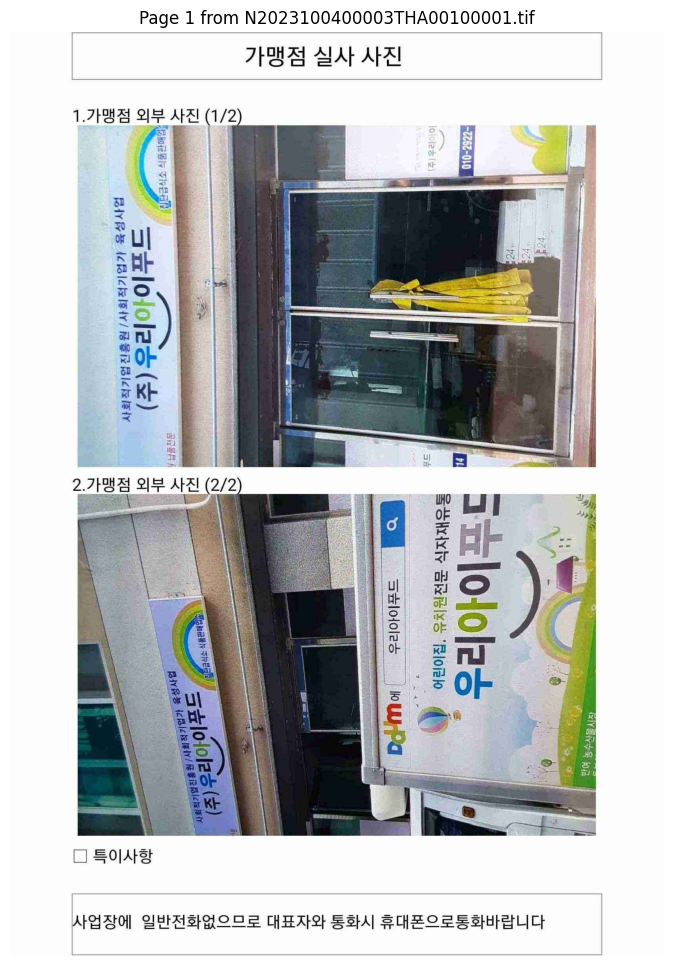

In [7]:
# -------------------------------------------------------------------------------------------------
# Scan TIFs and detect pages containing the configured search text
# Produces `all_files_to_process` with entries: {'path': Path, 'pages': [ints]}
# -------------------------------------------------------------------------------------------------
from PIL import Image, ImageSequence

supported = {'.tif', '.tiff'}
all_files_to_process = []

try:
    searcher_instance = TifTextSearcher(**searcher_overrides)
    root = Path(INPUT_DATA_DIRECTORY)
    tif_files = [p for p in root.rglob('*') if p.suffix.lower() in supported]
    logging.info('Found %d TIF files under %s', len(tif_files), root)

    for tif_path in tif_files:
        try:
            pages = searcher_instance.find_text_pages(tif_path)
            if pages:
                logging.info('%s: matched pages %s', tif_path.name, pages)
                all_files_to_process.append({'path': tif_path, 'pages': pages})
            else:
                logging.info('%s: no matched pages', tif_path.name)
        except Exception as e:
            logging.warning('OCR failed for %s: %s', tif_path, e)

    logging.info('Total files with matched pages: %d', len(all_files_to_process))
    
    # --- Visualize a sample detection ---
    if all_files_to_process:
        logging.info("Displaying first detected page as a visual check...")
        first_match = all_files_to_process[0]
        display_page_from_tif(first_match['path'], first_match['pages'][0])
        
except Exception as e:
    logging.error('OCR page detection step failed: %s', e, exc_info=True)
    all_files_to_process = []

## 5) 🏗️ Build Index from TIFs (YOLO Mode)

This section runs the main indexing workflow using the **YOLO object detection model** to find and extract photos.

1.  **Extracts Photos**: It processes the TIFs (either all pages or just the ones found by OCR) and uses the YOLO model to detect photos.
2.  **Saves Crops**: Each detected photo is saved as a separate image file in a specified directory.
3.  **Builds Index**: It then uses a feature extractor (like ResNet) to create a vector embedding for each cropped photo and stores these embeddings in a FAISS index for fast searching.

--- 🚀 OCR ENGINE INITIALIZATION (PaddleOCR) ---
  - INFO: Mapped language code 'ko' to 'korean' for PaddleOCR compatibility via config.

🔎 Checking for PaddleOCR models...
  - Resolved Detection path: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - Resolved Recognition path: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
- INFO: Model 'Classification' not resolved in provided path. Will use PaddleOCR default models (auto-download or cached).

🔧 Assembling PaddleOCR Parameters:
  - Language: 'korean'
  - GPU Acceleration: Enabled
  - Text Angle Classification: Enabled

⚙️ Initializing PaddleOCR engine with parameters:
  - use_angle_cls: True
  - lang: korean
  - det_model_dir: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - rec_model_dir: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
  - rec_batch_num: 6
  - show_log: False
[2025/09

Extracting Images from TIFs:   0%|          | 0/3 [00:00<?, ?it/s]

  - INFO: PaddleOCR resolved Classification model directory to: C:\Users\jeeb\.paddleocr\whl\cls\ch_ppocr_mobile_v2.0_cls_infer
2025-09-02 15:14:34,055 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...


Extracting Images from TIFs:  33%|███▎      | 1/3 [00:03<00:06,  3.05s/it]

CONSOLE DEBUG: N2023100400003THA00100001.tif p1: crops=8
2025-09-02 15:14:36,989 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...


Extracting Images from TIFs:  67%|██████▋   | 2/3 [00:03<00:01,  1.46s/it]

CONSOLE DEBUG: N2023100400119THA00100001.tif p1: crops=6
2025-09-02 15:14:37,322 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...


Extracting Images from TIFs: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

CONSOLE DEBUG: N2023100400122THA00100001.tif p1: crops=4
CONSOLE DEBUG: N2023100400003THA00100001.tif total crops=8
CONSOLE DEBUG: N2023100400119THA00100001.tif total crops=6
CONSOLE DEBUG: N2023100400122THA00100001.tif total crops=4
CONSOLE DEBUG: Total crops across all documents: 18



Main Indexing: 100%|██████████| 1/1 [00:00<00:00,  3.33batch/s]


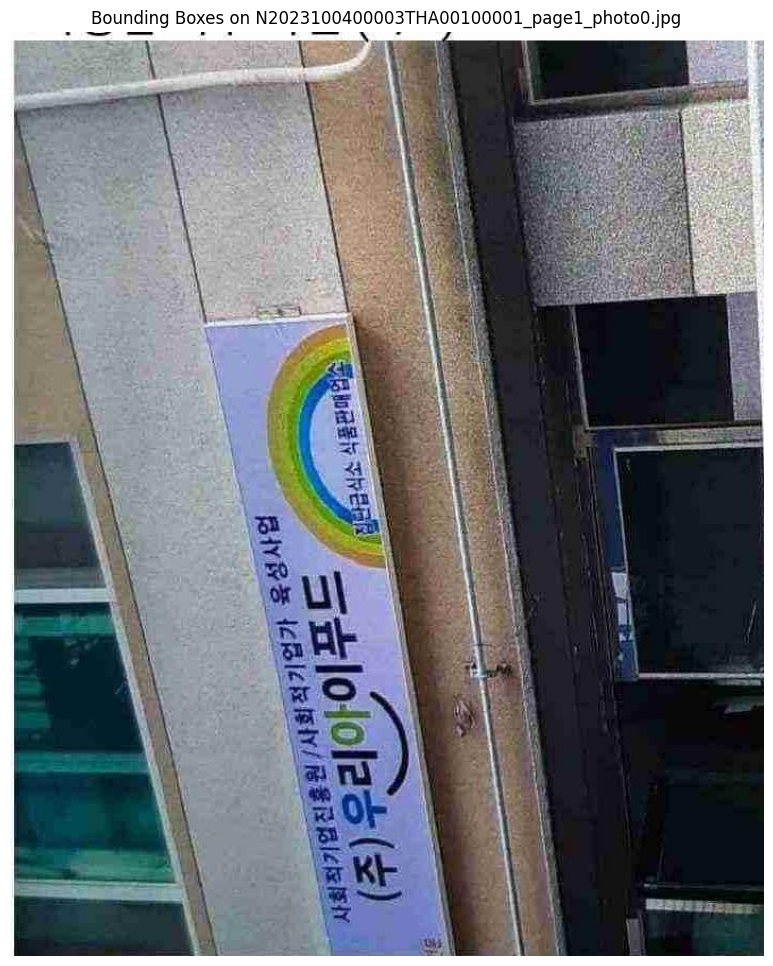

In [8]:
# -------------------------------------------------------------------------------------------------
# - Extracts photos from TIFs using YOLO
# - Saves crops into a chosen folder
# - Builds a vector index from that folder
# -------------------------------------------------------------------------------------------------
import shutil

if similarity_config:
    logging.info('=' * 80)
    logging.info('🏗️ Building Index from TIFs (YOLO Mode)')
    logging.info('=' * 80)

    try:
        # --- 5.1 Configure paths and cleaning options ----------------------------------
        # The `image_folder_to_index` is the critical path. It's where photo crops are
        # saved and where the indexer looks for images.
        CUSTOM_CROPS_DB_DIR = (
            MAIN_OUTPUT_DIRECTORY / 'yolo_crops_for_index'
        )
        # Set to True for a clean run, deleting any previously extracted photos.
        FORCE_CLEAN_CROPS_FOLDER = True

        # --- 5.2 Prepare a working config for this run ----------------------------------
        yolo_config = copy.deepcopy(similarity_config)

        # Set photo extraction to YOLO mode and merge the notebook's YOLO parameters
        pec = yolo_config.setdefault('photo_extractor_config', {})
        pec['photo_extraction_mode'] = 'yolo'
        pec.update(photo_extractor_config) # Use YOLO settings from Section 1

        # Set the indexing task parameters
        idx = yolo_config.setdefault('indexing_task', {})
        idx['input_tif_folder_for_indexing'] = str(INPUT_DATA_DIRECTORY)
        idx['image_folder_to_index'] = str(CUSTOM_CROPS_DB_DIR) # Override to our output dir

        # If OCR results are available, pass them to the workflow to process specific pages.
        # Otherwise, the workflow will scan all pages of all TIFs.
        if all_files_to_process:
            logging.info("Using OCR results: %d files will be processed.", len(all_files_to_process))
            idx['files_to_process_list'] = all_files_to_process
        else:
            logging.warning("No OCR results found or step was skipped. The workflow will process ALL pages of ALL TIFs.")
            idx['files_to_process_list'] = None

        # --- 5.3 Prepare destination folder ---------------------------------------------
        if FORCE_CLEAN_CROPS_FOLDER and CUSTOM_CROPS_DB_DIR.exists():
            logging.info('Cleaning destination crops folder: %s', CUSTOM_CROPS_DB_DIR)
            shutil.rmtree(CUSTOM_CROPS_DB_DIR, ignore_errors=True)
        CUSTOM_CROPS_DB_DIR.mkdir(parents=True, exist_ok=True)

        # --- 5.4 Run the TIF -> Crops -> Index workflow ---------------------------------
        result = build_index_from_tif_folder_workflow(
            config=yolo_config,
            project_root=PROJECT_ROOT,
            input_tif_folder_override=Path(INPUT_DATA_DIRECTORY)
        )

        # --- 5.5 Report and Visualize ---------------------------------------------------
        index_path = result.get('index_path')
        logging.info('✅ YOLO-based Index Build Complete.')
        logging.info('Crops saved to: %s', CUSTOM_CROPS_DB_DIR.resolve())
        logging.info('Extracted images (this run): %s', result.get('extracted_images_count'))
        logging.info('Indexed items (total in index): %s', result.get('indexed_image_count'))
        logging.info('Index path: %s', index_path)

        # Visualize one of the extracted crops as a sanity check
        image_files = list(CUSTOM_CROPS_DB_DIR.glob('*.jpg'))
        if image_files:
            logging.info("Displaying one of the extracted and indexed photos...")
            display_image_with_bbox(image_files[0], bboxes=[]) # Display without bbox

    except Exception as e:
        logging.error('YOLO-based index build failed: %s', e, exc_info=True)

else:
    logging.error('Skipping index build: similarity_config not loaded.')

## 6) 📊 Document Similarity Search (YOLO Mode)

This section performs a **document-level** similarity search. It takes each TIF in the input directory as a query and finds the most similar documents from the entire dataset.

The process for each query document is:
1.  **Extract Query Photos**: Use YOLO to find all photos in the query TIF.
2.  **Search for Each Photo**: For each extracted photo, search the FAISS index (built in Section 5) to find the most similar photos from the database.
3.  **Aggregate Scores**: Combine the similarity scores from all photos in the query document to produce a single, overall document similarity score.
4.  **Rank Documents**: Rank the database documents based on this aggregated score to find the top matches.

In [9]:
# -------------------------------------------------------------------------------------------------
# - Searches TIFs using YOLO-based crops
# - Executes batch search workflow (FAISS + brute-force fallback)
# -------------------------------------------------------------------------------------------------

if similarity_config:
    logging.info('='*80)
    logging.info('📊 Document Similarity Search (YOLO Mode)')
    logging.info('='*80)
    try:
        # --- 6.1 Prepare a working config -----------------------------------------------
        yolo_search_config = copy.deepcopy(similarity_config)

        # Set photo extraction to YOLO mode
        pec = yolo_search_config.setdefault('photo_extractor_config', {})
        pec['photo_extraction_mode'] = 'yolo'
        pec.update(photo_extractor_config) # Use YOLO settings from Section 1

        # Set search task parameters
        st = yolo_search_config.setdefault('search_task', {})
   
        st['input_tif_folder_for_search'] = str(INPUT_DATA_DIRECTORY)
        st['top_doc'] = TOP_DOCUMENTS_TO_RETURN
        st['top_k'] = 10 # Per-photo search fanout

        # The `bruteforce_db_folder` is a fallback if the FAISS index is not found or fails.
        # It must point to the same crops folder used for indexing in Section 5.
        st['bruteforce_db_folder'] = str(CUSTOM_CROPS_DB_DIR) # Defined in Section 5
        yolo_search_config.setdefault('indexing_task', {})['image_folder_to_index'] = str(CUSTOM_CROPS_DB_DIR)

        # --- 6.2 Execute search workflow ------------------------------------------------
        result = execute_tif_batch_search_workflow(
            config=yolo_search_config,
            project_root=PROJECT_ROOT,
            input_folder_override=Path(INPUT_DATA_DIRECTORY),
            top_doc_override=TOP_DOCUMENTS_TO_RETURN
        )

        # --- 6.3 Report and Visualize ---------------------------------------------------
        logging.info('✅ YOLO-based Document Search Complete.')
        
        # Display Global top_documents
        top_docs = result.get('top_documents', [])
        print('\\n=== Global Top Documents ===')
        for i, item in enumerate(top_docs or [], 1):
            print(f"{i:02d}. {item['document']}  score={item['score']:.4f}")

        # Display Per-query results
        per_query = result.get('per_query', []) or []
        print('\\n=== Per-Query Results ===')
        for entry in per_query:
            print(f"Query: {entry.get('query_document')}  photos={entry.get('num_query_photos')}  " f"agg={entry.get('aggregation_strategy_used')}  t={entry.get('elapsed_seconds', 0.0):.3f}s")
            for j, d in enumerate(entry.get('top_docs', []) or [], 1):
                print(f"   {j:02d}. {d.get('document')}  score={d.get('score', 0.0):.4f}")

        # Fallback warning if any
        if result.get('fallback_to_bruteforce_message'):
            print(f"\\n[Fallback] {result['fallback_to_bruteforce_message']}")

    except Exception as e:
        logging.error('YOLO-based document search failed: %s', e, exc_info=True)
else:
    logging.error('Skipping search: similarity_config not loaded.')

--- 🚀 OCR ENGINE INITIALIZATION (PaddleOCR) ---
  - INFO: Mapped language code 'ko' to 'korean' for PaddleOCR compatibility via config.

🔎 Checking for PaddleOCR models...
  - Resolved Detection path: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - Resolved Recognition path: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
- INFO: Model 'Classification' not resolved in provided path. Will use PaddleOCR default models (auto-download or cached).

🔧 Assembling PaddleOCR Parameters:
  - Language: 'korean'
  - GPU Acceleration: Enabled
  - Text Angle Classification: Enabled

⚙️ Initializing PaddleOCR engine with parameters:
  - use_angle_cls: True
  - lang: korean
  - det_model_dir: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - rec_model_dir: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
  - rec_batch_num: 6
  - show_log: False
[2025/09

Batch Searching TIFs:   0%|          | 0/3 [00:00<?, ?it/s]

  - INFO: PaddleOCR resolved Classification model directory to: C:\Users\jeeb\.paddleocr\whl\cls\ch_ppocr_mobile_v2.0_cls_infer
2025-09-02 15:14:45,340 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...
CONSOLE DEBUG: N2023100400003THA00100001.tif p1: crops=8
CONSOLE DEBUG: TIF 'N2023100400003THA00100001.tif': extracted 8 photo(s).
2025-09-02 15:14:46,767 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400003THA00100001_12.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:46,768 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:46,770 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2024030602077THA00100001_12.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs:  33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

2025-09-02 15:14:46,867 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...
CONSOLE DEBUG: N2023100400119THA00100001.tif p1: crops=6
CONSOLE DEBUG: TIF 'N2023100400119THA00100001.tif': extracted 6 photo(s).
2025-09-02 15:14:47,234 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:47,234 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2024030602067THA00100001_12.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:47,234 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2024030602077THA00100001_12.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs:  67%|██████▋   | 2/3 [00:02<00:00,  1.06it/s]

2025-09-02 15:14:47,319 - [INFO] - external.photo_extractor.photo_extractor.detection - Running YOLO detection on a batch of 1 page(s)...
CONSOLE DEBUG: N2023100400122THA00100001.tif p1: crops=4
CONSOLE DEBUG: TIF 'N2023100400122THA00100001.tif': extracted 4 photo(s).
2025-09-02 15:14:47,692 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400003THA00100001_13.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:47,692 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_13.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:47,702 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2024030602067THA00100001_13.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

CONSOLE DEBUG: N2023100400003THA00100001.tif total crops=8
CONSOLE DEBUG: N2023100400119THA00100001.tif total crops=6
CONSOLE DEBUG: N2023100400122THA00100001.tif total crops=4
CONSOLE DEBUG: Total crops across batch: 18
2025-09-02 15:14:47,713 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400003THA00100001_12.tif' not found in configured folders. Skipping copy.
2025-09-02 15:14:47,713 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.
\n=== Global Top Documents ===
01. N2023100400119THA00100001.tif  score=1.0000
02. N2023100400003THA00100001.tif  score=1.0000
03. N2023100400122THA00100001.tif  score=1.0000
04. N2023100400003THA00100001_12.tif  score=0.7247
05. N2023100400006THA00100001_12.tif  score=0.5025
\n=== Per-Query Results ===
Query: N2023100400003THA00100001.tif  photos=8  agg=max  t=1.619s
   01. N2023100400003THA00100001.tif  score=1.0000

## 7) 🏗️ Build Index from TIFs (BBox Mode)

This section provides an alternative to YOLO-based photo extraction. Instead of detecting photos with a model, it extracts image crops based on a **pre-defined list of bounding boxes**.

This mode is useful when:
- The location of the photo on the page is always the same.
- You want to ensure that only a specific region is indexed, ignoring all other content.
- You do not have a trained object detection model.

--- 🚀 OCR ENGINE INITIALIZATION (PaddleOCR) ---
  - INFO: Mapped language code 'ko' to 'korean' for PaddleOCR compatibility via config.

🔎 Checking for PaddleOCR models...
  - Resolved Detection path: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - Resolved Recognition path: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
- INFO: Model 'Classification' not resolved in provided path. Will use PaddleOCR default models (auto-download or cached).

🔧 Assembling PaddleOCR Parameters:
  - Language: 'korean'
  - GPU Acceleration: Enabled
  - Text Angle Classification: Enabled

⚙️ Initializing PaddleOCR engine with parameters:
  - use_angle_cls: True
  - lang: korean
  - det_model_dir: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - rec_model_dir: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
  - rec_batch_num: 6
  - show_log: False
[2025/09

Extracting Images from TIFs:  33%|███▎      | 1/3 [00:00<00:00,  5.14it/s]

  - INFO: PaddleOCR resolved Classification model directory to: C:\Users\jeeb\.paddleocr\whl\cls\ch_ppocr_mobile_v2.0_cls_infer
CONSOLE DEBUG: N2023100400003THA00100001.tif p1: crops=1


Extracting Images from TIFs: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

CONSOLE DEBUG: N2023100400119THA00100001.tif p1: crops=1
CONSOLE DEBUG: N2023100400122THA00100001.tif p1: crops=1
CONSOLE DEBUG: N2023100400003THA00100001.tif total crops=1
CONSOLE DEBUG: N2023100400119THA00100001.tif total crops=1
CONSOLE DEBUG: N2023100400122THA00100001.tif total crops=1
CONSOLE DEBUG: Total crops across all documents: 3



Main Indexing: 100%|██████████| 1/1 [00:00<00:00,  9.61batch/s]


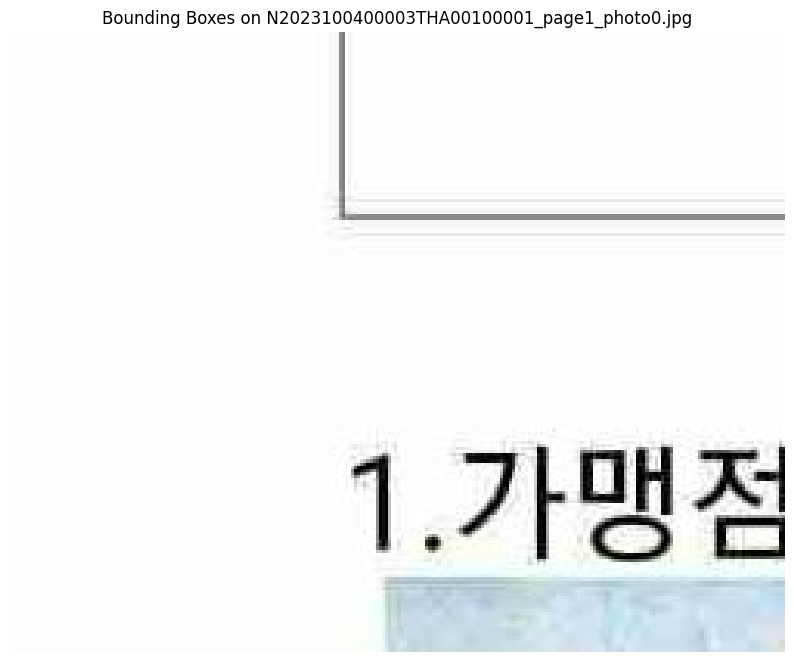

In [10]:
# -------------------------------------------------------------------------------------------------
# Build image index using predefined bounding boxes (no YOLO)
# -------------------------------------------------------------------------------------------------
if similarity_config:
    logging.info('='*80)
    logging.info('🏗️ Building Index from TIFs (BBox Mode)')
    logging.info('='*80)
    try:
        # --- 7.1 Configure paths and cleaning options ----------------------------------
        BBOX_CROPS_DB_DIR = MAIN_OUTPUT_DIRECTORY / 'bbox_crops_for_index'
        FORCE_CLEAN_BBOX_FOLDER = True

        # --- 7.2 Prepare a working config for this run ----------------------------------
        bbox_config = copy.deepcopy(similarity_config)
        pec = bbox_config.setdefault('photo_extractor_config', {})
        pec['photo_extraction_mode'] = 'bbox'
        pec['bbox_extraction'] = {
            'bbox_list': BBOX_LIST,       # From Section 1
            'bbox_format': BBOX_FORMAT,     # From Section 1
            'normalized': BBOX_NORMALIZED,  # From Section 1
        }
        
        idx = bbox_config.setdefault('indexing_task', {})
        idx['image_folder_to_index'] = str(BBOX_CROPS_DB_DIR)

        # --- 7.3 Prepare destination folder ---------------------------------------------
        if FORCE_CLEAN_BBOX_FOLDER and BBOX_CROPS_DB_DIR.exists():
            logging.info('Cleaning destination BBox crops folder: %s', BBOX_CROPS_DB_DIR)
            shutil.rmtree(BBOX_CROPS_DB_DIR, ignore_errors=True)
        BBOX_CROPS_DB_DIR.mkdir(parents=True, exist_ok=True)

        # --- 7.4 Run the workflow -------------------------------------------------------
        result = build_index_from_tif_folder_workflow(
            config=bbox_config,
            project_root=PROJECT_ROOT,
            input_tif_folder_override=Path(INPUT_DATA_DIRECTORY)
        )
        logging.info('✅ BBox-based Index Build Complete.')

        # --- 7.5 Visualize a sample BBox crop ---
        image_files = list(BBOX_CROPS_DB_DIR.glob('*.jpg'))
        if image_files:
            logging.info("Displaying one of the extracted BBox crops...")
            display_image_with_bbox(image_files[0], bboxes=[])

    except Exception as e:
        logging.error('BBox-based index build failed: %s', e, exc_info=True)
else:
    logging.error('Skipping index build: similarity_config not loaded.')

## 8) 📊 Document Similarity Search (BBox Mode)

This section performs document similarity search using the index built from **fixed bounding boxes** in the previous step. The logic is identical to the YOLO-based search, but the underlying photo crops are different.

In [11]:
# -------------------------------------------------------------------------------------------------
# Run similarity search using the BBox-based index
# -------------------------------------------------------------------------------------------------
if similarity_config:
    logging.info('='*80)
    logging.info('📊 Document Similarity Search (BBox Mode)')
    logging.info('='*80)
    try:
        # --- 8.1 Prepare a working config -----------------------------------------------
        bbox_search_config = copy.deepcopy(similarity_config)
        pec = bbox_search_config.setdefault('photo_extractor_config', {})
        pec['photo_extraction_mode'] = 'bbox'
        pec['bbox_extraction'] = {
            'bbox_list': BBOX_LIST,
            'bbox_format': BBOX_FORMAT,
            'normalized': BBOX_NORMALIZED,
        }
        
        # Point to the BBox crops folder for fallback and indexing info
        bbox_search_config.setdefault('indexing_task', {})['image_folder_to_index'] = str(BBOX_CROPS_DB_DIR)
        bbox_search_config.setdefault('search_task', {})['bruteforce_db_folder'] = str(BBOX_CROPS_DB_DIR)

        # --- 8.2 Execute search workflow ------------------------------------------------
        result = execute_tif_batch_search_workflow(
            config=bbox_search_config,
            project_root=PROJECT_ROOT,
            input_folder_override=Path(INPUT_DATA_DIRECTORY),
            top_doc_override=TOP_DOCUMENTS_TO_RETURN
        )
        
        # --- 8.3 Report Results ---------------------------------------------------------
        logging.info('✅ BBox-based Document Search Complete.')
        top_docs = result.get('top_documents', [])
        print('\\n=== Global Top Documents (BBox) ===')
        for i, item in enumerate(top_docs or [], 1):
            print(f"{i:02d}. {item['document']}  score={item['score']:.4f}")

    except Exception as e:
        logging.error('BBox-based document search failed: %s', e, exc_info=True)
else:
    logging.error('Skipping search: similarity_config not loaded.')

--- 🚀 OCR ENGINE INITIALIZATION (PaddleOCR) ---
  - INFO: Mapped language code 'ko' to 'korean' for PaddleOCR compatibility via config.

🔎 Checking for PaddleOCR models...
  - Resolved Detection path: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - Resolved Recognition path: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
- INFO: Model 'Classification' not resolved in provided path. Will use PaddleOCR default models (auto-download or cached).

🔧 Assembling PaddleOCR Parameters:
  - Language: 'korean'
  - GPU Acceleration: Enabled
  - Text Angle Classification: Enabled

⚙️ Initializing PaddleOCR engine with parameters:
  - use_angle_cls: True
  - lang: korean
  - det_model_dir: C:\Users\jeeb\.paddlex\official_models\PP-OCRv3_det\Multilingual_PP-OCRv3_det_infer
  - rec_model_dir: C:\Users\jeeb\.paddlex\official_models\korean_PP-OCRv3_rec\korean_PP-OCRv3_rec_infer
  - rec_batch_num: 6
  - show_log: False
[2025/09

Batch Searching TIFs:   0%|          | 0/3 [00:00<?, ?it/s]

  - INFO: PaddleOCR resolved Classification model directory to: C:\Users\jeeb\.paddleocr\whl\cls\ch_ppocr_mobile_v2.0_cls_infer
CONSOLE DEBUG: N2023100400003THA00100001.tif p1: crops=1
CONSOLE DEBUG: TIF 'N2023100400003THA00100001.tif': extracted 1 photo(s).
2025-09-02 15:14:59,763 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs:  33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]

CONSOLE DEBUG: N2023100400119THA00100001.tif p1: crops=1
CONSOLE DEBUG: TIF 'N2023100400119THA00100001.tif': extracted 1 photo(s).
2025-09-02 15:14:59,978 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs:  67%|██████▋   | 2/3 [00:00<00:00,  4.47it/s]

CONSOLE DEBUG: N2023100400122THA00100001.tif p1: crops=1
CONSOLE DEBUG: TIF 'N2023100400122THA00100001.tif': extracted 1 photo(s).
2025-09-02 15:15:00,180 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.


Batch Searching TIFs: 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

CONSOLE DEBUG: N2023100400003THA00100001.tif total crops=1
CONSOLE DEBUG: N2023100400119THA00100001.tif total crops=1
CONSOLE DEBUG: N2023100400122THA00100001.tif total crops=1
CONSOLE DEBUG: Total crops across batch: 3
2025-09-02 15:15:00,189 - [WARNING] - core_engine.image_similarity_system.workflow - Parent TIF 'N2023100400006THA00100001_12.tif' not found in configured folders. Skipping copy.
\n=== Global Top Documents (BBox) ===
01. N2023100400122THA00100001.tif  score=1.0000
02. N2023100400119THA00100001.tif  score=1.0000
03. N2023100400003THA00100001.tif  score=1.0000
04. N2023100400006THA00100001_12.tif  score=0.3264


## 9) ✨ Bonus: Direct Single Image-to-Image Similarity Search

This section demonstrates a more fundamental capability: taking a **single image file** (e.g., a JPG or PNG) and finding the most similar images in the FAISS index. This bypasses the document/TIF structure entirely and works directly with images.

2025-09-02 15:15:00,588 - [WARNING] - core_engine.image_similarity_system.utils - Could not copy result file for rank 1: Source file not found at 'D:\frm_git\tif_doc_nd_image_similarity_search\TifDoc_nd_image_similarity_search\instance\database_images\N2023100400003THA00100001_12_page1_photo1.jpg'. Skipping this file.
2025-09-02 15:15:00,595 - [WARNING] - core_engine.image_similarity_system.utils - Could not copy result file for rank 2: Source file not found at 'D:\frm_git\tif_doc_nd_image_similarity_search\TifDoc_nd_image_similarity_search\instance\database_images\N2023100400003THA00100001_12_page1_photo0.jpg'. Skipping this file.
2025-09-02 15:15:00,596 - [WARNING] - core_engine.image_similarity_system.utils - Could not copy result file for rank 3: Source file not found at 'D:\frm_git\tif_doc_nd_image_similarity_search\TifDoc_nd_image_similarity_search\instance\database_images\N2023100400006THA00100001_12_page1_photo1.jpg'. Skipping this file.
2025-09-02 15:15:00,596 - [WARNING] - co

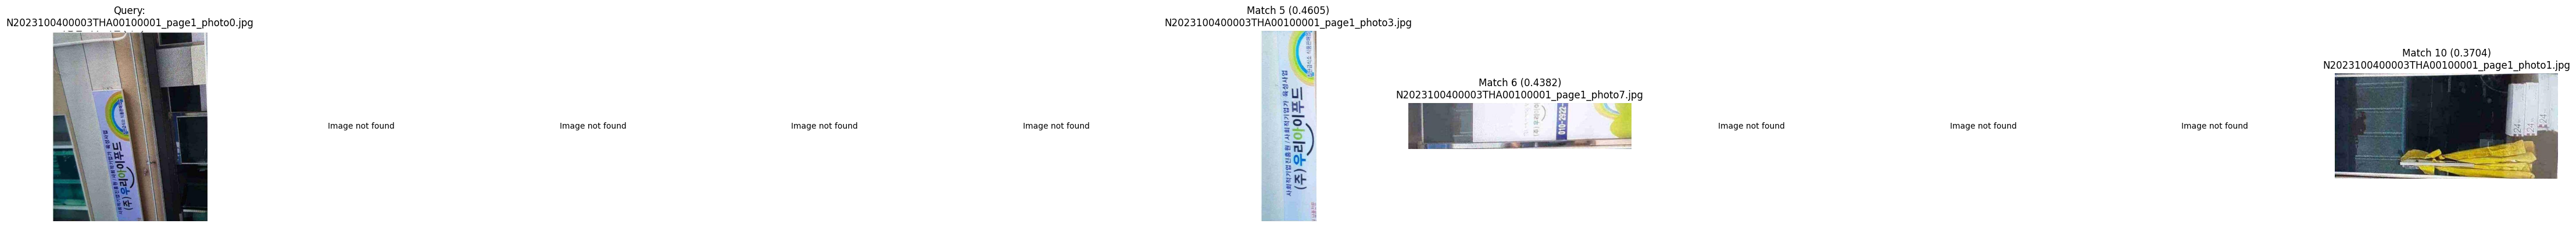

In [12]:
# -------------------------------------------------------------------------------------------------
# Search using a single query image against the built embeddings
# -------------------------------------------------------------------------------------------------
ENABLE_DIRECT_IMAGE_SEARCH = True # Set to False to disable this section
# ❗️ IMPORTANT: Set this to the path of an actual image crop from one of the previous steps.
# For example: list(CUSTOM_CROPS_DB_DIR.glob('*.jpg'))[0] 
QUERY_IMAGE_PATH = '' # Must be a valid image path
TOP_K_RESULTS_TO_FIND = 10

# Automatically pick a query image if path is not set
if ENABLE_DIRECT_IMAGE_SEARCH and not QUERY_IMAGE_PATH:
    if 'CUSTOM_CROPS_DB_DIR' in locals() and CUSTOM_CROPS_DB_DIR.exists():
        candidate_images = list(CUSTOM_CROPS_DB_DIR.glob('*.jpg'))
        if candidate_images:
            QUERY_IMAGE_PATH = str(candidate_images[0])
            logging.info("QUERY_IMAGE_PATH was not set. Automatically selected: %s", QUERY_IMAGE_PATH)

if ENABLE_DIRECT_IMAGE_SEARCH and similarity_config and (QUERY_IMAGE_PATH and Path(QUERY_IMAGE_PATH).is_file()):
    logging.info('='*80)
    logging.info('✨ Direct Single Image-to-Image Similarity Search')
    logging.info('='*80)
    try:
        single_search_config = copy.deepcopy(similarity_config)
        single_search_config['action'] = 'search'
        st = single_search_config.setdefault('search_task', {})
   
        st['query_image_path'] = QUERY_IMAGE_PATH
        st['batch_query_image_folder_path'] = None
        st['top_k'] = TOP_K_RESULTS_TO_FIND
        # Point to the folder of images that were indexed
        st['bruteforce_db_folder'] = str(Path(QUERY_IMAGE_PATH).parent)

        logging.info('Querying with image: %s', QUERY_IMAGE_PATH)
        result = execute_image_similarity_workflow(config=single_search_config, project_root=PROJECT_ROOT)
        logging.info('✅ Direct Image Search Complete.')
        
        summary = result.get('search_operation_summary') or {}
        results_list = (summary or {}).get('results', [])
        
        # Visualize the results
        display_search_results(QUERY_IMAGE_PATH, results_list, TOP_K_RESULTS_TO_FIND)
        
    except Exception as e:
        logging.error('Direct image search failed: %s', e, exc_info=True)
else:
    logging.info('Skipping Direct Single Image Search: disabled, config missing, or QUERY_IMAGE_PATH is invalid.')

## 10) ✨ Bonus: Batch Image-to-Image Similarity Search

This section extends the previous concept by using an **entire folder of images** as queries. For each image in the specified directory, it runs a similarity search against the index.

In [13]:
# -------------------------------------------------------------------------------------------------
# Search using an entire folder of images as queries
# -------------------------------------------------------------------------------------------------
ENABLE_BATCH_IMAGE_SEARCH = False # Set to True to run this section
# This should be a folder containing images you want to use as queries.
# We default to the YOLO crops folder created in Section 5.
BATCH_QUERY_IMAGE_DIRECTORY = str(CUSTOM_CROPS_DB_DIR if 'CUSTOM_CROPS_DB_DIR' in locals() else '')
TOP_K_RESULTS_FOR_BATCH = 5

if ENABLE_BATCH_IMAGE_SEARCH and similarity_config and Path(BATCH_QUERY_IMAGE_DIRECTORY).is_dir():
    logging.info('='*80)
    logging.info('✨ Batch Image-to-Image Similarity Search')
    logging.info('='*80)
    try:
        batch_search_config = copy.deepcopy(similarity_config)
        batch_search_config['action'] = 'search'
        st = batch_search_config.setdefault('search_task', {})
   
        st['batch_query_image_folder_path'] = BATCH_QUERY_IMAGE_DIRECTORY
        st['query_image_path'] = None
        st['top_k'] = TOP_K_RESULTS_FOR_BATCH
        st['bruteforce_db_folder'] = BATCH_QUERY_IMAGE_DIRECTORY

        logging.info('Batch searching with folder: %s', BATCH_QUERY_IMAGE_DIRECTORY)
        result = execute_image_similarity_workflow(config=batch_search_config, project_root=PROJECT_ROOT)
        logging.info('✅ Batch Image Search Complete.')
        
        summary = result.get('search_operation_summary') or {}
        success_list = summary.get('successful_searches', []) or []
        
        # Visualize the first few results
        for i, s in enumerate(success_list[:3]): # Show results for first 3 queries
            q_details = (s or {}).get('query_image_details', {})
            q_path = q_details.get('original_path')
            if q_path:
                print(f'--- Results for Query: {Path(q_path).name} ---')
                display_search_results(q_path, (s or {}).get('results', []), TOP_K_RESULTS_FOR_BATCH)

    except Exception as e:
        logging.error('Batch image search failed: %s', e, exc_info=True)
else:
    logging.info('Skipping Batch Image Search: disabled, config missing, or batch directory is invalid.')

## 11) 🧪 Debugging & Exploration

This section contains useful snippets for debugging the pipeline and exploring the system's components. You can run these cells independently to inspect configurations, test extractors, or view indexed data.

In [14]:
# --- 1. Inspect the final loaded configuration ---
import yaml
from pathlib import Path

def make_paths_printable(d):
    """Recursively converts Path objects to strings in a dict or list."""
    if isinstance(d, dict):
        return {k: make_paths_printable(v) for k, v in d.items()}
    if isinstance(d, list):
        return [make_paths_printable(i) for i in d]
    if isinstance(d, Path):
        return str(d)
    return d

if 'yolo_search_config' in locals():
    print("--- YOLO Search Config Used ---")
    # Convert Path objects to strings for clean printing before dumping to YAML
    config_to_print = make_paths_printable(yolo_search_config)
    printable_config = yaml.dump(config_to_print, default_flow_style=False, sort_keys=False)
    print(printable_config)

# --- 2. Manually test the PhotoExtractor on a single TIF page ---
MANUAL_TEST_EXTRACTOR = False
if MANUAL_TEST_EXTRACTOR and all_files_to_process:
    try:
        # Setup extractor
        extractor = PhotoExtractor(config=photo_extractor_config, project_root=PROJECT_ROOT)
        
        # Get a sample TIF and page
        test_file = all_files_to_process[0]['path']
        test_page = all_files_to_process[0]['pages'][0]
        
        # Extract the page image
        with Image.open(test_file) as tif:
            tif.seek(test_page - 1)
            page_image = tif.copy()
        
        # Run extraction
        logging.info(f'Manually running PhotoExtractor on page {test_page} of {test_file.name}')
        extracted_photos, metadata = extractor.extract_photos_from_image(
            image=page_image,
            extraction_mode='yolo', # or 'bbox'
            source_filename=test_file.name
        )
        
        logging.info(f'Found {len(extracted_photos)} photos.')
        
        # Visualize the results
        if extracted_photos:
            bboxes = [meta['bbox_xyxy'] for meta in metadata]
            # To visualize on the original page, we need to save it temporarily
            temp_page_path = MAIN_OUTPUT_DIRECTORY / 'temp_page_for_viz.png'
            page_image.save(temp_page_path)
            display_image_with_bbox(temp_page_path, bboxes)
            temp_page_path.unlink() # Clean up
            
    except Exception as e:
        logging.error("Manual extractor test failed: %s", e, exc_info=True)

# --- 3. List all files in one of the crop directories ---
if 'CUSTOM_CROPS_DB_DIR' in locals() and CUSTOM_CROPS_DB_DIR.exists():
    print(f'\\n--- Contents of {CUSTOM_CROPS_DB_DIR} ---')
    all_crops = list(CUSTOM_CROPS_DB_DIR.rglob('*.*'))
    for i, crop_path in enumerate(all_crops[:10]): # Print first 10
        print(f'{i+1:02d}. {crop_path.name}')
    if len(all_crops) > 10:
        print(f'...and {len(all_crops) - 10} more.')

--- YOLO Search Config Used ---
shared_paths:
  database_output_directory: ../instance/database
user_database: null
user_database_postgresql:
  database_name: ${POSTGRES_DB}
  host: ${POSTGRES_HOST}
  port: ${POSTGRES_PORT}
  user: ${POSTGRES_USER}
  password: ${POSTGRES_PASSWORD}
  table_name: ${POSTGRES_TABLE_NAME:users}
  show_request_config: false
system_info:
  system_name: JK Image Similarity System
  version: 1.0.0
  description: Configuration for image feature extraction, indexing, and search.
  show_model_info: true
input_mode:
  doc_input_start: key
  key_input_config_path: external/key_input/key_input_config.yaml
action: all
logging:
  level: INFO
  version: 1
  root:
    handlers:
    - console
    - file_app
    level: INFO
  loggers:
    core_engine:
      handlers:
      - console
      - file_core
      level: INFO
      propagate: false
    httpx:
      handlers:
      - console
      - file_core
      level: WARNING
      propagate: false
feature_extractor:
  model_na